In [ ]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import csv
import datetime
import multiprocessing as mp
import numpy as np
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import svm
import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
import numpy as np
from sklearn import linear_model
from sklearn.metrics import log_loss
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LogisticRegression

In [ ]:
def CommonNeighbors(u, v, g):
    u_neighbors = set(g.neighbors(u))
    v_neighbors = set(g.neighbors(v))
    return len(u_neighbors.intersection(v_neighbors))
def common_neighbors(g, edges):
    result = []
    for edge in edges:
        node_one, node_two = edge[0], edge[1]
        num_common_neighbors = 0
        try:
            neighbors_one, neighbors_two = g.neighbors(node_one), g.neighbors(node_two)
            for neighbor in neighbors_one:
                if neighbor in neighbors_two:
                    num_common_neighbors += 1
            result.append((node_one, node_two, num_common_neighbors))
        except:
            pass
    return result

In [ ]:
def AdamicAdar(u, v, g):
    u_neighbors = set(g.neighbors(u))
    v_neighbors = set(g.neighbors(v))
    aa = 0
    for i in u_neighbors.intersection(v_neighbors):
        aa += 1 / math.log(len(g.neighbors(i)))
    return aa

In [ ]:
def ResourceAllocation(u, v, g):
    u_neighbors = set(g.neighbors(u))
    v_neighbors = set(g.neighbors(v))
    ra = 0
    for i in u_neighbors.intersection(v_neighbors):
        ra += 1 / float(len(g.neighbors(i)))
    return ra

In [ ]:
def JaccardCoefficent(u, v, g):
    u_neighbors = set(g.neighbors(u))
    v_neighbors = set(g.neighbors(v))
    return len(u_neighbors.intersection(v_neighbors)) / float(len(u_neighbors.union(v_neighbors)))

In [ ]:
def PreferentialAttachment(u, v, g):
    return len(g.neighbors(u))*len(g.neighbors(v))

In [ ]:
def AllFeatures(u,v,g1, g2):
    try:
        cn = CommonNeighbors(u, v, g2)
        aa = AdamicAdar(u, v, g2)
        ra = ResourceAllocation(u, v, g2)
        jc = JaccardCoefficent(u, v, g2)
        pa = PreferentialAttachment(u, v, g2)

        delta_cn = cn - CommonNeighbors(u, v, g1)
        delta_aa = aa - AdamicAdar(u, v, g1)
        delta_ra = ra - ResourceAllocation(u, v, g1)
        delta_jc = jc - JaccardCoefficent(u, v, g1)
        delta_pa = pa - PreferentialAttachment(u, v, g1)
        return {"cn":cn, "aa": aa, "ra":ra, "jc":jc, "pa":pa,
            "delta_cn": delta_cn, "delta_aa": delta_aa, "delta_ra": delta_ra,
             "delta_jc": delta_jc, "delta_pa": delta_pa}
    except:
        pass

In [ ]:
feature_set = [common_neighbors,nx.resource_allocation_index,
                   nx.jaccard_coefficient,
                   nx.adamic_adar_index,
                   nx.preferential_attachment
                   ]

In [ ]:
def produce_fake_edge(g, neg_g,num_test_edges):
    i = 0
    while i < num_test_edges:
        edge = random.sample(g.nodes(), 2)
        try:
            shortest_path = nx.shortest_path_length(g,source=edge[0],target=edge[1])
            if shortest_path >= 2:
                neg_g.add_edge(edge[0],edge[1], positive="False")
                i += 1
        except:
            pass

In [ ]:
def create_graph_from_file(filename):
    print("----------------build graph--------------------")
    f = open(filename, "rb")
    g = nx.read_edgelist(f)
    return g

In [ ]:
def sample_extraction(g, pos_num, neg_num, neg_mode, neg_distance=2, delete=1):

    print("----------------extract positive samples--------------------")
    # randomly select pos_num as test edges
    pos_sample = random.sample(g.edges(), pos_num)
    sample_g = nx.Graph()
    sample_g.add_edges_from(pos_sample, positive="True")
    nx.write_edgelist(sample_g, "sample_positive_" +str(pos_num)+ ".txt", data=['positive'])

    # adding non-existing edges
    print("----------------extract negative samples--------------------")
    i = 0
    neg_g = nx.Graph()
    produce_fake_edge(g,neg_g,neg_num)
    nx.write_edgelist(neg_g, "sample_negative_" +str(neg_num)+ ".txt", data=["positive"])
    neg_sample = neg_g.edges()
    neg_g.add_edges_from(pos_sample,positive="True")
    nx.write_edgelist(neg_g, "sample_combine_" +str(pos_num + neg_num)+ ".txt", data=["positive"])

    # remove the positive sample edges, the rest is the training set
    if delete == 0:
        return pos_sample, neg_sample
    else:
        g.remove_edges_from(pos_sample)
        nx.write_edgelist(g, "training.txt", data=False)

        return pos_sample, neg_sample

In [ ]:
def feature_extraction(g, pos_sample, neg_sample, feature_name, model="single", combine_num=5):

    data = []
    if model == "single":
        print ("-----extract feature:", feature_name.__name__, "----------")
        preds = feature_name(g, pos_sample)
        feature = [feature_name.__name__] + [i[2] for i in preds]
        label = ["label"] + ["Pos" for i in range(len(feature))]
        preds = feature_name(g, neg_sample)
        feature1 = [i[2] for i in preds]
        feature = feature + feature1
        label = label + ["Neg" for i in range(len(feature1))]
        data = [feature, label]
        data = transpose(data)
        print("----------write the feature to file---------------")
        write_data_to_file(data, "features_" + model + "_" + feature_name.__name__ + ".csv")
    else:
        label = ["label"] + ["1" for i in range(len(pos_sample))] + ["0" for i in range(len(neg_sample))]
        for j in feature_name:
            print ("-----extract feature:", j.__name__, "----------")
            preds = j(g, pos_sample)
            feature = [j.__name__] + [i[2] for i in preds]
            preds = j(g, neg_sample)
            feature = feature + [i[2] for i in preds]
            data.append(feature)

        data.append(label)
        data = transpose(data)
        print("----------write the features to file---------------")
        write_data_to_file(data, "features_" + model + "_" + str(combine_num) + ".csv")
    return data


def write_data_to_file(data, filename):
    csvfile = open(filename, "w")
    writer = csv.writer(csvfile)
    for i in data:
        writer.writerow(i)
    csvfile.close()
def transpose(data):
    return [list(i) for i in zip(*data)]

In [ ]:
def main(filename="facebook_combined.txt", pos_num=0.1, neg_num=0.1, model="combined", combine_num=1,feature_name=common_neighbors, neg_mode="hard"):
    if combine_num==2:
        pos_num=0.3;
        neg_num=0.3;
    g = create_graph_from_file(filename)
    num_edges = g.number_of_edges()
    pos_num = int(num_edges * pos_num)
    neg_num = int(num_edges * neg_num)
    pos_sample, neg_sample = sample_extraction(g, pos_num, neg_num,neg_mode)
    train_data = feature_extraction(g, pos_sample, neg_sample, feature_name, model, combine_num)

In [ ]:
fn="facebook_combined.txt";
cn=2;

f = open(fn, "rb")
G = nx.read_edgelist(f,create_using=nx.Graph())
plt.figure(figsize=(10,10))
pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)
plt.show()

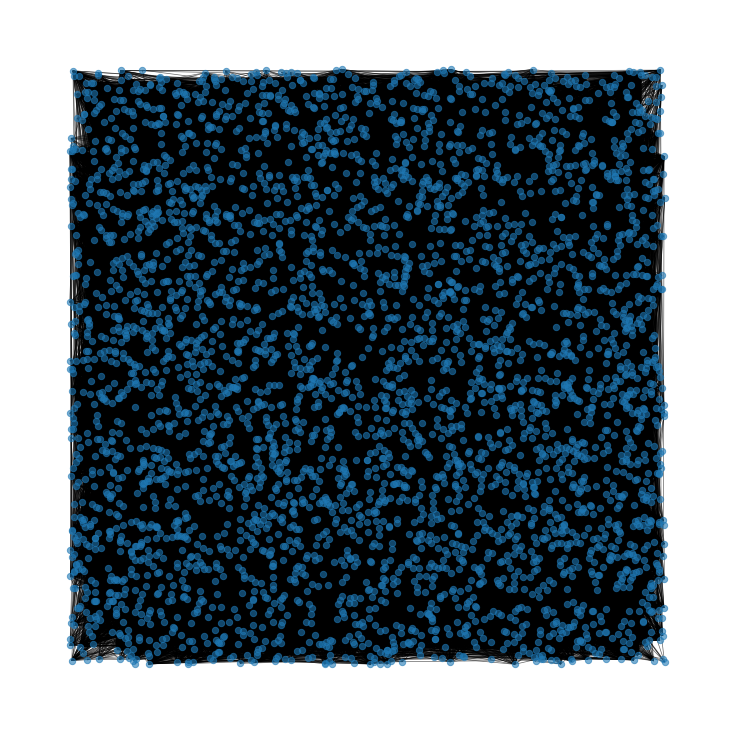

In [ ]:
G = nx.read_edgelist(fn)
plt.figure(figsize=(10,10))
pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    annot_kws = {"ha": 'left',"va": 'top', "size":15}
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f",annot_kws=annot_kws, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", annot_kws=annot_kws, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", annot_kws=annot_kws, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [ ]:
#Run this line to genrate feature Set
main(filename=fn,model="combined",combine_num=cn, feature_name=feature_set, neg_mode="easy")

----------------build graph--------------------
----------------extract positive samples--------------------
----------------extract negative samples--------------------
-----extract feature: common_neighbors ----------
-----extract feature: resource_allocation_index ----------
-----extract feature: jaccard_coefficient ----------
-----extract feature: adamic_adar_index ----------
-----extract feature: preferential_attachment ----------
----------write the features to file---------------


In [ ]:
r=np.loadtxt(open("features_combined_"+str(cn)+".csv", "rb"), delimiter=",", skiprows=1);

In [ ]:
l,b=r.shape;
print(l)
print(b)

79365
6


In [ ]:
data = pd.read_csv("features_combined_"+str(cn)+".csv")

In [ ]:
data.head()

,common_neighbors,resource_allocation_index,jaccard_coefficient,adamic_adar_index,preferential_attachment,label
0,1,0.319011,0.163636,2.614586,768,1
1,1,0.411327,0.221622,8.860079,12733,1
2,0,0.404455,0.259740,8.659202,8113,1
3,0,0.066905,0.043478,0.783968,620,1
4,0,0.335426,0.215686,5.218175,3060,1


In [ ]:
data.shape

(79365, 6)

In [ ]:
x = data.iloc[:, data.columns != 'label']
y = data[['label']].to_numpy()


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.5, random_state=0)
X_train = normalize(X_train, axis=0, norm='max')
X_test = normalize(X_test, axis=0, norm='max')
scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

In [ ]:
def logistic(training, training_labels, testing, testing_labels):
    clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='ovr').fit(training, training_labels)
    start = datetime.datetime.now()
    clf.fit(training, training_labels)
    result=clf.predict(testing)
    print ("Linear accuracy:", accuracy_score(testing_labels, result))
    finish = datetime.datetime.now()
    print ((finish-start).seconds)
    plot_confusion_matrix(testing_labels, result)

Linear accuracy: 0.6695562331476955
0


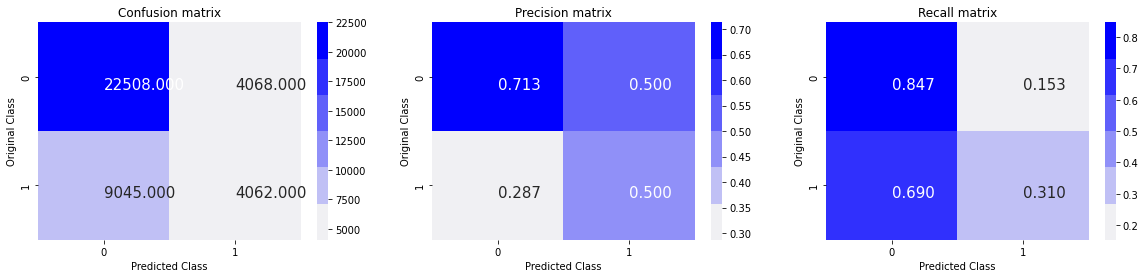

In [ ]:
logistic(X_train,Y_train,X_test,Y_test)

In [ ]:
def mySvm(training, training_labels, testing, testing_labels):
    #Support Vector Machine
    start = datetime.datetime.now()
    clf = svm.SVC()
    clf.fit(training, training_labels)
    print ("+++++++++ Finishing training the SVM classifier ++++++++++++")
    result = clf.predict(testing)

    print ("SVM accuracy:", accuracy_score(testing_labels, result))
    #keep the time
    finish = datetime.datetime.now()
    print ((finish-start).seconds)

In [ ]:
mySvm(X_train,Y_train,X_test,Y_test)

+++++++++ Finishing training the SVM classifier ++++++++++++
SVM accuracy: 0.5093236568894265
215


In [ ]:
def ANN(training, training_labels, testing, testing_labels):
    clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(15,9), random_state=1)
    start = datetime.datetime.now()
    clf.fit(training, training_labels)
    print ("+++++++++ Finishing training the ANN classifier ++++++++++++")
    result = clf.predict(testing)

    print ("ANN accuracy:", accuracy_score(testing_labels, result))
    #keep the time
    finish = datetime.datetime.now()
    print ((finish-start).seconds)

In [ ]:
ANN(X_train,Y_train,X_test,Y_test)

+++++++++ Finishing training the ANN classifier ++++++++++++
ANN accuracy: 0.5043846386452978
11


Estimators =  10 Train Score 0.483227524063076 test Score 0.48325299715733533
Estimators =  50 Train Score 0.48895566022413506 test Score 0.4877909116937298
Estimators =  100 Train Score 0.4834092120913826 test Score 0.48438853371829244
Estimators =  250 Train Score 0.4838934712134269 test Score 0.48437113402061854
Estimators =  450 Train Score 0.4832909105837918 test Score 0.48407327941904604


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

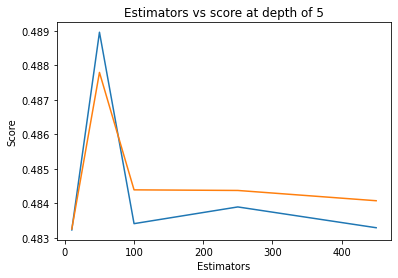

In [ ]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, 
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(X_train,Y_train)
    train_sc = f1_score(Y_train,clf.predict(X_train))
    test_sc = f1_score(Y_test,clf.predict(X_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.468661443573929 test Score 0.4791719051211131
depth =  9 Train Score 0.4954951248611511 test Score 0.4734515102681708
depth =  11 Train Score 0.5129927952724034 test Score 0.47259855974612475
depth =  15 Train Score 0.5543516526501076 test Score 0.4658938569513445
depth =  20 Train Score 0.5779543963887496 test Score 0.4572564612326044
depth =  35 Train Score 0.5851538461538461 test Score 0.45477416108681346
depth =  50 Train Score 0.5852119719935369 test Score 0.45433073914895267
depth =  70 Train Score 0.5852119719935369 test Score 0.45433073914895267
depth =  130 Train Score 0.5852119719935369 test Score 0.45433073914895267


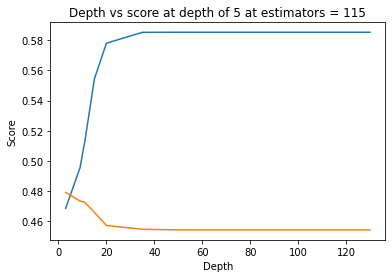

In [ ]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(X_train,Y_train)
    train_sc = f1_score(Y_train,clf.predict(X_train))
    test_sc = f1_score(Y_test,clf.predict(X_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [ ]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
        max_depth=3, max_features='auto', max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        min_samples_leaf=52, min_samples_split=120,
        min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
start = datetime.datetime.now()
clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)
print(accuracy_score(Y_test,Y_pred))
finish = datetime.datetime.now()
print((finish-start).seconds)
test_sc = f1_score(Y_test,Y_pred)
print(test_sc)

0.6869188317415518
1
0.4842673308426733
